In [1]:
pip install -q snscrape transformers matplotlib wordcloud seaborn scikit-plot contractions nltk regex tweetnlp

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Importing Libraries
from flask import Flask, render_template, request, url_for
from PIL import Image
import pandas as pd
import numpy as np
import tweepy
import warnings
import snscrape.modules.twitter as sntwitter
import requests
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tweetnlp
import seaborn as sns
import plotly.graph_objects as go
import scikitplot as skplt
import seaborn as sns
import contractions
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer

ImportError: cannot import name 'Image' from 'PIL' (unknown location)

In [2]:
TExtract = pd.read_csv('TwitterExtract.csv',encoding= 'MacRoman')

In [3]:
TExtract.head()

,Datetime,Text,Username,Retweet,Views,Search Criteria,"Positive (P), Negative(N), Both(B), Neutral(U)"
0,10/02/2023,Say What You Want But This Harry Potter Is The...,NaN,1,967,Harry Potter,P
1,01/02/2023,Where?S The Edd Bank Of America BeyoncÈ Presale?,AmyScarlata,1,212,Bank Of America,P
2,26/01/2023,@Besoccerfr Pep Guardiola And Pulisitch,Khaled_Dz_2006,0,19,Pep Guardiola,P
3,10/02/2023,@Bluedinifree @Marshablackburn He Was Getting ...,JamesAR1116,0,17,Netflix,U
4,10/02/2023,@Wizard_Coder @Bearbulltraders I Trade Perpetu...,RecoveryTraders,0,37,Ftx,U


In [4]:
TExtract.rename(columns={"Positive (P), Negative(N), Both(B), Neutral(U)": "Sentiment"}, inplace=True)

sentiment_mapping = {'P': 'positive', 'N': 'negative', 'U': 'neutral', 'B': 'both'} # Define a mapping of old values to new values
TExtract['Sentiment'] = TExtract['Sentiment'].replace(sentiment_mapping)

In [5]:
valid_sentiments = ['positive', 'negative', 'neutral'] # Define a list of valid sentiments
TExtract = TExtract[TExtract['Sentiment'].isin(valid_sentiments)]

In [6]:
TExtract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27279 entries, 0 to 29998
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Datetime         27279 non-null  object
 1   Text             27279 non-null  object
 2   Username         24536 non-null  object
 3   Retweet          27279 non-null  int64 
 4   Views            27279 non-null  int64 
 5   Search Criteria  27279 non-null  object
 6   Sentiment        27279 non-null  object
dtypes: int64(2), object(5)
memory usage: 1.7+ MB


In [7]:
print ('============================================')
print ("Search Criteria breakdown")
print ('============================================')
TExtract['Search Criteria'].value_counts().head(20)

Search Criteria breakdown


Harry Potter    745
Adele           708
Netflix         697
Lebron James    690
Amouranth       670
Liz Truss       655
Primark         646
Coca-cola       622
Amazon          612
Andrew Tate     603
Wayfair         594
Walmart         582
Chelsea         575
Iphone          567
Tesco           563
Arsenal         560
Paypal          559
Chris Brown     539
Burna Boy       535
Asda            522
Name: Search Criteria, dtype: int64

In [8]:
TExtract['TextClean'] = TExtract['Text']

In [9]:
Filteredtweets = TExtract[TExtract['Search Criteria'] == 'Iphone'].copy()

In [10]:
Filteredtweets.reset_index(inplace=True)

In [11]:
Filteredtweets.head()

,index,Datetime,Text,Username,Retweet,Views,Search Criteria,Sentiment,TextClean
0,5,07/02/2023,"? Tagged #Hashtag,#Ciberamenazas,#Ciberconsejo...",rafemi,0,27,Iphone,neutral,"? Tagged #Hashtag,#Ciberamenazas,#Ciberconsejo..."
1,19,28/12/2022,"Hey @Apple , With All Of These System Updates,...",MrAveryBrown,0,77,Iphone,positive,"Hey @Apple , With All Of These System Updates,..."
2,65,26/01/2023,Can I Ask All You Apple Product Users: Why Wou...,cunderw12,0,147,Iphone,positive,Can I Ask All You Apple Product Users: Why Wou...
3,237,31/01/2023,@Apple Please Fix The Voice Notes Not Being Ab...,NandyVersatil,0,30,Iphone,positive,@Apple Please Fix The Voice Notes Not Being Ab...
4,248,24/12/2022,Rip #Twitterforiphone And #Twitterforandroid #...,ninaadsadaphal,0,18,Iphone,positive,Rip #Twitterforiphone And #Twitterforandroid #...


NameError: name 'plt' is not defined

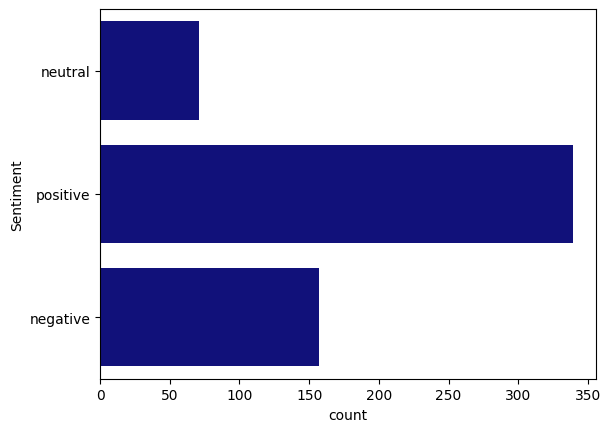

In [12]:
sns.countplot(y='Sentiment', data=Filteredtweets, color = 'darkblue')
plt.title('Manual Sentiment Classification')
plt.show()

In [13]:
# remove '\n', lowercase all letters
Filteredtweets['TextClean'] = Filteredtweets['TextClean'].apply(lambda x: x.replace('\n',' ').lower())

# expand contractions
Filteredtweets['TextClean'] = Filteredtweets['TextClean'].apply(lambda x: contractions.fix(x))

# remove punctuations
Filteredtweets['TextClean'] = Filteredtweets['TextClean'].apply(lambda x: re.sub(r'[^\w\s]','',x))

#remove HTML tags
Filteredtweets['TextClean'] = Filteredtweets['TextClean'].apply(lambda x: re.sub(re.compile('<.*?>'), '', x))

#remove consecutive characters that occur three or more times in a row, and replace them with just two occurrences of that character.
Filteredtweets['TextClean'] = Filteredtweets['TextClean'].apply(lambda x: re.compile(r"(.)\1{2,}").sub(r"\1\1", x))

# Removing extra spaces
Filteredtweets['TextClean'] = Filteredtweets['TextClean'].apply(lambda x: re.sub(' +',' ',x))

# Removing stop words
#stop_words = set(stopwords.words('english'))
#Filteredtweets['TextClean'] = Filteredtweets['TextClean'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Tokenize the text data using NLTK
# Filteredtweets['TextClean'] = Filteredtweets['TextClean'].apply(lambda x: word_tokenize(x))

In [14]:
Filteredtweets[['Text', 'TextClean']]

,Text,TextClean
0,"? Tagged #Hashtag,#Ciberamenazas,#Ciberconsejo...",tagged hashtagciberamenazasciberconsejosciber...
1,"Hey @Apple , With All Of These System Updates,...",hey apple with all of these system updates i n...
2,Can I Ask All You Apple Product Users: Why Wou...,can i ask all you apple product users why woul...
3,@Apple Please Fix The Voice Notes Not Being Ab...,apple please fix the voice notes not being abl...
4,Rip #Twitterforiphone And #Twitterforandroid #...,rip twitterforiphone and twitterforandroid twi...
...,...,...
562,@Velcocinemas Last Time License This Time #Iph...,velcocinemas last time license this time iphon...
563,1/ It's So Unfortunate That Ftx One Of The Wor...,1 it is so unfortunate that ftx one of the wor...
564,"Today, I Changed My #Iphone Apps Settings. 1. ...",today i changed my iphone apps settings 1 appl...
565,#Iphone Chargers Should Be Called Apple Juice,iphone chargers should be called apple juice


In [15]:
Filteredtweets['TextClean']

0       tagged hashtagciberamenazasciberconsejosciber...
1      hey apple with all of these system updates i n...
2      can i ask all you apple product users why woul...
3      apple please fix the voice notes not being abl...
4      rip twitterforiphone and twitterforandroid twi...
                             ...                        
562    velcocinemas last time license this time iphon...
563    1 it is so unfortunate that ftx one of the wor...
564    today i changed my iphone apps settings 1 appl...
565         iphone chargers should be called apple juice
566    kodak 35mm film is so pricey i cant afford to ...
Name: TextClean, Length: 567, dtype: object

In [16]:
# Load the model
model = tweetnlp.load_model('sentiment')

# Define the sentiment analysis function
def get_sentiment(text):
    return model.sentiment(text)['label']

# Apply the function to each row of the 'filtertweet[textclean]' column and store the result in a new column called 'sentiment'
Filteredtweets['Tweetsentiment'] = Filteredtweets['TextClean'].apply(get_sentiment)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
# Load the model
model = tweetnlp.load_model('sentiment')

# Define the sentiment analysis function
def get_sentiment(text):
    return model.sentiment(text)['label']

# Apply the function to each row of the 'filtertweet[textclean]' column and store the result in a new column called 'sentiment'
Filteredtweets['TweetsentimentNoCleaning'] = Filteredtweets['Text'].apply(get_sentiment)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
Filteredtweets['Tweetsentiment'].value_counts()

neutral     239
negative    192
positive    136
Name: Tweetsentiment, dtype: int64

In [20]:
Filteredtweets['TweetsentimentNoCleaning'].value_counts()

neutral     262
negative    176
positive    129
Name: TweetsentimentNoCleaning, dtype: int64

In [21]:
Filteredtweets['Sentiment'].value_counts()

positive    339
negative    157
neutral      71
Name: Sentiment, dtype: int64

In [ ]:
#Sentiment Classification Plot
# create the data for the plot
data = Filteredtweets['Tweetsentiment'].value_counts()
# create the bar plot
fig = go.Figure(data=[go.Bar(x=data.values, y=data.index, orientation='h', marker_color='darkblue')])
# customize the plot layout
fig.update_layout(title='Sentiment Classification', xaxis_title='Count', yaxis_title='Sentiment')
# save the plot as an image file
fig.write_image("static/SentimentClass.png")

In [ ]:
import base64
from io import BytesIO
import plotly.graph_objects as go

# create the data for the plot
data = Filteredtweets['Tweetsentiment'].value_counts()

# create the bar plot
fig = go.Figure(data=[go.Bar(x=data.values, y=data.index, orientation='h', marker_color='darkblue')])

# customize the plot layout
fig.update_layout(title='Sentiment Classification', xaxis_title='Count', yaxis_title='Sentiment')

# save the plot as an image file
img_bytes = fig.to_image(format='png')
encoded_image = base64.b64encode(img_bytes).decode('utf-8')

encoded_image

# pass the encoded image string to the template
#return render_template('index.html', plot=encoded_image)


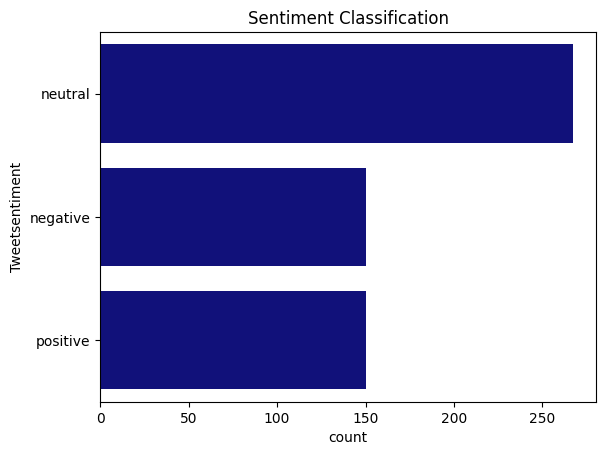

NameError: name 'SentimentClass' is not defined

In [22]:
sns.countplot(y='Tweetsentiment', data=Filteredtweets, color = 'darkblue')
plt.title('Sentiment Classification')
plt.show()

SentimentClass.savefig('static/SentimentClass.png')
plt.close()

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
sns.countplot(y='Tweetsentiment', data=Filteredtweets, color='darkblue', ax=ax)
ax.set_title('Sentiment Classification')
# Save the figure as a variable
SentimentClass = ax.get_figure()
# Or save it as an image
SentimentClass.savefig('static/SentimentClass.png')


In [ ]:
sns.countplot(y='TweetsentimentNoCleaning', data=Filteredtweets, color = 'darkblue')
plt.title('Tweetnlp with no Cleaning Sentiment Classification')
plt.show()

In [ ]:
sns.countplot(y='Sentiment', data=Filteredtweets, color = 'darkblue')
plt.title('Manual Sentiment Classification')
plt.show()

In [ ]:
Filteredtweets['CompareCnU'] = Filteredtweets['TweetsentimentNoCleaning'] == Filteredtweets['Tweetsentiment']

In [ ]:
Filteredtweets['CompareCnU'].value_counts()

In [ ]:
# Filter rows where Compare is False
false_compare = Filteredtweets.loc[Filteredtweets['CompareCnU'] == False, ['Text', 'TweetsentimentNoCleaning', 'Tweetsentiment', 'CompareCnU']]

# Print the resulting dataframe
pd.set_option('display.max_colwidth', None)
false_compare.head(20)

In [ ]:
# Print the resulting dataframe
pd.set_option('display.max_colwidth', None)
false_compare.tail(20)

In [ ]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
 

 

In [ ]:
# Wordcloud with positive tweets
positive_tweets = Filteredtweets['TextClean'][Filteredtweets['Tweetsentiment'] == 'positive']
stop_words = ["iphone"] + list(STOPWORDS)
positive_wordcloud = WordCloud(max_font_size=60, max_words=50, background_color="white", stopwords = stop_words).generate(str(positive_tweets))
plt.figure()
plt.title("Positive Tweets - Wordcloud")
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
# Wordcloud with positive tweets
positive_tweets = Filteredtweets['TextClean'][Filteredtweets['Tweetsentiment'] == 'negative']
stop_words = ["iphone"] + list(STOPWORDS)
positive_wordcloud = WordCloud(max_font_size=60, max_words=50, background_color="white", stopwords = stop_words).generate(str(positive_tweets))
plt.figure()
plt.title("Negative Tweets - Wordcloud")
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
OverallSentiment = Filteredtweets['Tweetsentiment'].mode()[0]

In [ ]:
print('OverallSentiment: '+ OverallSentiment)

In [ ]:
# Group the dataframe by date and sentiment class and count the number of tweets in each group
tweet_counts = Filteredtweets.groupby(['Datetime', 'Tweetsentiment']).size().unstack(fill_value=0)

# Plot the line graph
fig, ax = plt.subplots(figsize=(10, 6))
tweet_counts.plot(ax=ax)

# Add titles and labels
ax.set_title('Tweet Sentiment over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Tweets')
ax.legend(title='Sentiment Class', loc='upper left')
Sentimentovertime = ax.get_figure()
Sentimentovertime.savefig('static/Sentimentovertime.png')


In [ ]:
    #Sentiment Classification Plot
    fig, ax = plt.subplots(figsize=(8,6))
    sns.countplot(y='Tweetsentiment', data=tweets_df, color='darkblue', ax=ax)
    ax.set_title('Sentiment Classification')
    # Save the figure as a variable
    SentimentClass = ax.get_figure()
    # save it as an image
    SentimentClass.savefig('static/SentimentClass.png')

In [ ]:
Filteredtweets2 = Filteredtweets.copy()

In [ ]:
# convert the Datetime column to a pandas datetime object
Filteredtweets2['Datetime'] = pd.to_datetime(Filteredtweets2['Datetime'], dayfirst=True)

In [ ]:
sentiment_coding = {'positive':1, 'negative':-1, 'neutral': 0} # Define a mapping of old values to new values
Filteredtweets2['Tweetsentiment'] = Filteredtweets2['Tweetsentiment'].replace(sentiment_coding)

In [ ]:
Filteredtweets2.info()

In [ ]:
Filteredtweets2.head(1)

In [ ]:
# convert the Datetime column to a pandas datetime object
Filteredtweets2['Datetime'] = pd.to_datetime(Filteredtweets2['Datetime'])

# group by day and compute the mode of the Tweetsentiment column
daily_mode = Filteredtweets2.groupby(pd.Grouper(key='Datetime', freq='D'))['Tweetsentiment'].apply(lambda x: x.mode())

# plot the daily mode of the Tweetsentiment column
fig, ax = plt.subplots(figsize=(10, 6))
daily_mode.plot(ax=ax, kind='line')
ax.set_xlabel('Date')
ax.set_ylabel('Mode of Tweetsentiment')
ax.set_title('Daily Mode of Tweetsentiment')
plt.show()

In [ ]:
# convert the Datetime column to a pandas datetime object
Filteredtweets2['Datetime'] = pd.to_datetime(Filteredtweets2['Datetime'])

# group by week and compute the mode of the Tweetsentiment column
weekly_mode = Filteredtweets2.groupby(pd.Grouper(key='Datetime', freq='W'))['Tweetsentiment'].apply(lambda x: x.mean())

# plot the weekly mode of the Tweetsentiment column
fig, ax = plt.subplots(figsize=(10, 6))
weekly_mode.plot(ax=ax, kind='line')
ax.set_xlabel('Date')
ax.set_ylabel('Average of Tweetsentiment')
ax.set_title('Weekly Average of Tweetsentiment')
plt.show()


In [ ]:
# convert the Datetime column to a pandas datetime object
Filteredtweets2['Datetime'] = pd.to_datetime(Filteredtweets2['Datetime'])

# group by week and compute the mode of the Tweetsentiment column
weekly_mode = Filteredtweets2.groupby(pd.Grouper(key='Datetime', freq='W'))['Tweetsentiment'].apply(lambda x: x.mean())

# plot the weekly mode of the Tweetsentiment column
fig, ax = plt.subplots(figsize=(10, 6))
weekly_mode.plot(ax=ax, kind='line')
ax.set_xlabel('Date')
ax.set_ylabel('Average of Tweetsentiment')
ax.set_title('Weekly Average of Tweetsentiment')
ax.axhline(y=0, color='gray', linestyle='--')
plot_WeeklyAverage = ax.get_figure()
plt.show()


In [ ]:
plot_WeeklyAverage

In [ ]:
# Wordcloud with positive tweets
negative_tweets = Filteredtweets['TextClean'][Filteredtweets['Tweetsentiment'] == 'negative']
stop_words = ["iphone"] + list(STOPWORDS)
negative_wordcloud = WordCloud(max_font_size=60, max_words=50, background_color="white", stopwords=stop_words).generate(str(negative_tweets))

# Save the figure as a variable
fig = plt.figure()
plt.title("Negative Tweets - Wordcloud")
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")

# Display the figure using plt.show()
plt.show()

In [ ]:
topic = 'Iphone'

In [ ]:
# Wordcloud with Negative tweets
NegativeWC = plt.figure()
plt.title("Negative Tweets - Wordcloud")
plt.imshow(WordCloud(width=700, height=400,max_font_size=80, max_words=50, background_color="white", stopwords=([topic.lower()] + list(STOPWORDS))).generate(str(Filteredtweets['TextClean'][Filteredtweets['Tweetsentiment'] == 'negative'])), interpolation="bilinear")
plt.axis("off")

# Display the figure using plt.show()
plt.show()
NegativeWC.savefig('static/Nwordcloud.png')
plt.close()

PositiveWC = plt.figure()
plt.title("Positive Tweets - Wordcloud")
plt.imshow(WordCloud(width=700, height=400,max_font_size=80, max_words=50, background_color="white", stopwords=([topic.lower()] + list(STOPWORDS))).generate(str(Filteredtweets['TextClean'][Filteredtweets['Tweetsentiment'] == 'positive'])), interpolation="bilinear")
plt.axis("off")

# Display the figure using plt.show()
plt.show()
PositiveWC.savefig('static/Pwordcloud.png')
plt.close()

In [ ]:
NegativeWC.savefig('static/Nwordcloud.png')
PositiveWC.savefig('static/Pwordcloud.png')

In [ ]:
PositiveWC

In [ ]:
NegativeWC

In [ ]:
# Wordcloud with positive tweets
positive_tweets = Filteredtweets['TextClean'][Filteredtweets['Tweetsentiment'] == 'negative']
stop_words = ["iphone"] + list(STOPWORDS)
positive_wordcloud = WordCloud(max_font_size=60, max_words=50, background_color="white", stopwords = stop_words).generate(str(positive_tweets))
plt.figure()
plt.title("Negative Tweets - Wordcloud")
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
PositiveWC = plt.figure()
plt.title("Positive Tweets - Wordcloud")
plt.imshow(WordCloud(width=700, height=400,max_font_size=80, max_words=50, background_color="white", stopwords=([topic.lower()] + list(STOPWORDS))).generate(str(Filteredtweets['TextClean'][Filteredtweets['Tweetsentiment'] == 'positive'])), interpolation="bilinear")
plt.axis("off")

# Display the figure using plt.show()
plt.show()
plt.close()

In [ ]:
(Filteredtweets['Text'][Filteredtweets['Tweetsentiment'] == 'negative']).head()

In [ ]:
Filteredtweets =Filteredtweets.sort_values(by=['Views'], ascending=False)

In [ ]:
Filteredtweets[Filteredtweets['Tweetsentiment'] == 'negative'].sort_values(by=['Views'], ascending=False).head(10)


In [ ]:
top_negative_tweets = Filteredtweets.loc[Filteredtweets['Tweetsentiment'] == 'negative'].sort_values(by=['Views'], ascending=False).loc[:, ['Datetime', 'Text', 'Views']].head(10)
top_negative_tweets

In [ ]:
top_positive_tweets = Filteredtweets.loc[Filteredtweets['Tweetsentiment'] == 'positive'].sort_values(by=['Views'], ascending=False).loc[:, ['Datetime', 'Text', 'Views']].head(10)
top_positive_tweets

In [ ]:
top_negative_tweets

In [33]:
location = 'london'

In [34]:
location = location.title()

In [35]:
location

'London'